In [103]:
import numpy as np
import os
import matplotlib.pyplot as plt
import enviroment_no_visual as enviroment_no_visual
import enviroment_visual as enviroment_visual
import tensorflow as tf
import keras

Implementazione di un buffer circolare che permetta inserimento/cancellazione degli elementi e accesso random veloce. 

In [104]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = np.empty(max_size, dtype=object)
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = np.random.randint(self.size, size=batch_size)
        return self.buffer[indices]
    
    def sample_experiences(self, batch_size):
        batch = self.sample(batch_size)
        states, actions, rewards, next_states, game_over = [
            np.array([experience[field_index] for experience in batch])
                        for field_index in range(5)]
        return states, actions, rewards, next_states, game_over

Funzione per creare una neural network lineare 

In [105]:
def Linear_QNet(units):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=[11]))
    model.add(keras.layers.Dense(units, activation='relu'))
    model.add(keras.layers.Dense(units=3))
    return model

In [106]:
class QTrainer:
    def __init__(self, model, lr, gamma):
        self.model = model
        self.gamma = gamma
        self.optimizer = keras.optimizers.Adam(learning_rate=lr)
        self.loss_fn = keras.losses.mean_squared_error
        
    @tf.function
    def train_step(self, states, actions, rewards, next_states, dones):
        next_Q_values = self.model(next_states)
        max_next_Q_values = tf.reduce_max(next_Q_values, axis=1)
        # Equazione di Bellman: Q value = reward + discount factor * expected future reward
        target_Q_values = rewards + (1 - dones) * self.gamma * max_next_Q_values
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)  
            Q_values = tf.reduce_sum(all_Q_values * actions, axis=1, keepdims=True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))
        # Backpropagation
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

In [107]:
def convert_to_tensorflow(states, actions, rewards, next_states, dones):
    states = tf.convert_to_tensor(states, dtype=tf.float32)
    actions = tf.convert_to_tensor(actions, dtype=tf.float32)
    rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
    next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
    dones = tf.convert_to_tensor(dones, dtype=tf.float32)
    return states, actions, rewards, next_states, dones

In [108]:
class Agent:
    def __init__(self, lr, gamma, max_memory, batch_size, nn_model):
        self.n_games = 0
        self.epsilon = 1  
        self.lr = lr
        self.gamma = gamma  
        self.memory = ReplayBuffer(max_size=max_memory)
        self.batch_size = batch_size
        self.model = nn_model
        self.trainer = QTrainer(self.model, lr=self.lr, gamma=self.gamma)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append(convert_to_tensorflow(state, action, reward, next_state, done))

    def train_memory(self):
        states, actions, rewards, next_states, dones = self.memory.sample_experiences(self.batch_size)
        self.trainer.train_step(states, actions, rewards, next_states, dones)

    def epsilon_greedy_policy(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(3)
        else:
            Q_values = self.model(state[np.newaxis])
            return np.argmax(Q_values[0])
        
    def get_action(self, state):
        final_move = [0, 0, 0]  
        move = self.epsilon_greedy_policy(state)
        final_move[move] = 1
        return final_move
    
    def train_agent(self, N_GAME, visual=True):
        if visual:
            env = enviroment_visual.SnakeGameAI(speed=0)
        else:
            env = enviroment_no_visual.SnakeGameAI()
        score_list = []
        record = 0
        n_eps_zero = int(N_GAME*0.7)
        step=0 #
        while self.n_games < N_GAME:
            state_old = env.get_state()
            final_move = self.get_action(state_old)
            state_new, reward, done, score = env.play_step(final_move)
            self.remember(state_old, final_move, reward, state_new, done)
            if done:
                env.reset()
                self.n_games += 1
                self.train_memory()
                print(f"\rGame: {self.n_games}, Epsilon: {self.epsilon:3f}, Score: {score}, Record: {record}, lr: {self.lr:3f} Step eseguiti: {step}. ", end="")
                self.epsilon = max(((n_eps_zero - self.n_games) / n_eps_zero), 0)
                self.lr = self.lr - 0.05/N_GAME
                if score > record:
                    record = score
                    self.save_model()
                score_list.append(score)
            step+=1
        return score_list

    def save_model(self, model_dir_path="./DQNmodel", file_name='model.keras'):
        if not os.path.exists(model_dir_path):
            print(f"La cartella non esiste. Sarà creata con nome: {model_dir_path}")
            os.mkdir(model_dir_path)
        file_name = os.path.join(model_dir_path, file_name)
        self.model.save(file_name)

Mostra andamento dello score per partita durante il training

In [109]:
def plot_trand(scores, save_path=None):
    zeros = [0 for i in range(49)]
    calcola_media = lambda i: sum(scores[i-50:i+1]) / 50
    media_precedenti = zeros + list(map(calcola_media, range(49, len(scores))))
    max_mean_value = max(media_precedenti)
    max_mean_index = media_precedenti.index(max_mean_value)
    plt.plot(scores, label='Score')
    plt.plot(media_precedenti, label='Mean score delle ultime 50 partite')
    plt.text(max_mean_index, max_mean_value, f'{max_mean_value:.2f}', fontsize=12, color="darkorange", ha='center')

    plt.title("Andamento del training.")
    plt.xlabel("Partite")
    plt.ylabel("Score")
    plt.legend()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Crea e allena un agente

Game: 500, Epsilon: 0.000000, Score: 9, Record: 56, lr: 0.000100 Step eseguiti: 105602.  

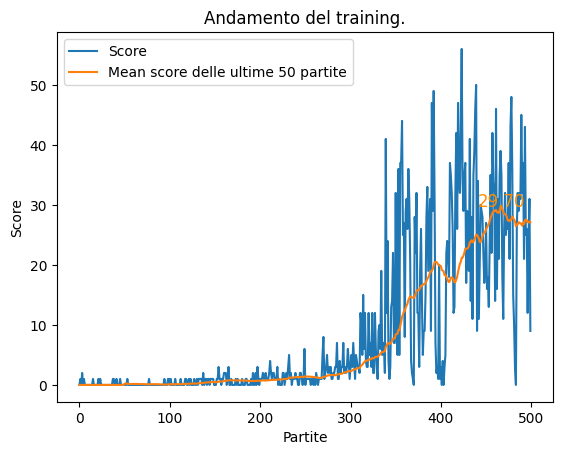

In [110]:
model = Linear_QNet(units=128)
agent = Agent(lr=0.05, gamma=0.9, max_memory=20_000, batch_size=1024, nn_model=model)
score_list = agent.train_agent(N_GAME=500, visual=False)
plot_trand(score_list)

In [111]:
'''try_lr = [0.05, 0.001, 0.0005]
try_max_memory = [20_000, 50_000, 75_000]
try_batch_size = [1024, 2048, 4096]
try_units = [64, 128, 256]
scores = []
for curr_lr in try_lr:
    for curr_max_memory in try_max_memory:
        for curr_batch_size in try_batch_size:
            for curr_units in try_units:
                print("imgs/lr:"+str(curr_lr)+"max_memory:"+str(curr_max_memory)+"batch_size:"+str(curr_batch_size)+"units:"+str(curr_units))
                agent = Agent(lr=curr_lr, gamma=0.9, max_memory=curr_max_memory, batch_size=curr_batch_size, nn_model=Linear_QNet(curr_units))
                score_list = agent.train_agent(N_GAME=500, visual=False)
                plot_trand(score_list, "imgs/lr:"+str(curr_lr)+"max_memory:"+str(curr_max_memory)+"batch_size:"+str(curr_batch_size)+"units:"+str(curr_units)+".png")
                scores.append(score_list)
'''

'try_lr = [0.05, 0.001, 0.0005]\ntry_max_memory = [20_000, 50_000, 75_000]\ntry_batch_size = [1024, 2048, 4096]\ntry_units = [64, 128, 256]\nscores = []\nfor curr_lr in try_lr:\n    for curr_max_memory in try_max_memory:\n        for curr_batch_size in try_batch_size:\n            for curr_units in try_units:\n                print("imgs/lr:"+str(curr_lr)+"max_memory:"+str(curr_max_memory)+"batch_size:"+str(curr_batch_size)+"units:"+str(curr_units))\n                agent = Agent(lr=curr_lr, gamma=0.9, max_memory=curr_max_memory, batch_size=curr_batch_size, nn_model=Linear_QNet(curr_units))\n                score_list = agent.train_agent(N_GAME=500, visual=False)\n                plot_trand(score_list, "imgs/lr:"+str(curr_lr)+"max_memory:"+str(curr_max_memory)+"batch_size:"+str(curr_batch_size)+"units:"+str(curr_units)+".png")\n                scores.append(score_list)\n'

Mostra visualmente una partita dell'Agente

In [ ]:
def load_model_from_file(model_dir_path="./DQNmodel", file_name='model.keras'):
    file_path = os.path.join(model_dir_path, file_name)
    model = keras.models.load_model(file_path)
    return model
    
env_visual = enviroment_visual.SnakeGameAI(speed=0)
model = load_model_from_file()
game_over = False
state = env_visual.get_state()
while not game_over:
    action = np.argmax(model(state[np.newaxis])[0])
    final_move = [0,0,0]
    final_move[action] = 1
    state, reward, game_over, score = env_visual.play_step(final_move)
env_visual.quit()